In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
data = pd.read_excel('Data/lending.xlsx', parse_dates=True,index_col='year')

In [9]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 1976-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    49 non-null     float64
dtypes: float64(1)
memory usage: 784.0 bytes


In [31]:
data['lending'] = data.rate / 100

In [59]:
data.head()

,rate,lending
year,,
1976-01-01,10.206429,0.102064
1977-01-01,10.206429,0.102064
1978-01-01,10.206429,0.102064
1979-01-01,10.206429,0.102064
1980-01-01,10.515714,0.105157


In [10]:
data.index

DatetimeIndex(['1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

Text(0, 0.5, 'lending_rate')

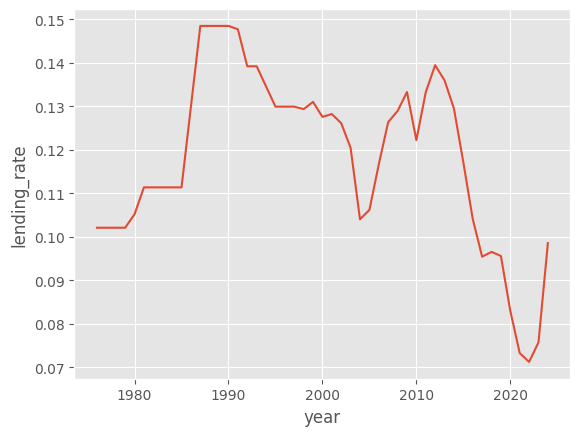

In [33]:
plt.style.use('ggplot')
plt.plot(data.index, data.lending)
plt.xlabel('year')
plt.ylabel('lending_rate')

Checking stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller

In [34]:
adf = adfuller(data['lending'])
print(f'p-value is {np.round(adf[1],2)}')

p-value is 0.1


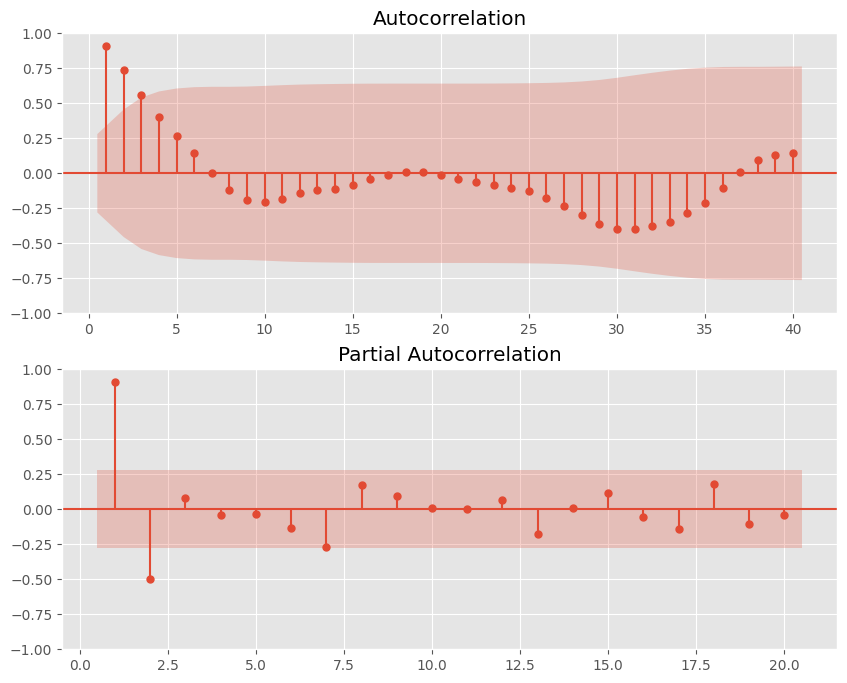

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (10, 8))
plot_acf(data.lending, lags = 40, zero=False, ax=ax1)
plot_pacf(data.lending, lags= 20, zero=False, ax=ax2)
plt.show()

The series is non-stationary. A first difference is taken.

In [35]:
data_diff = data.diff().dropna()

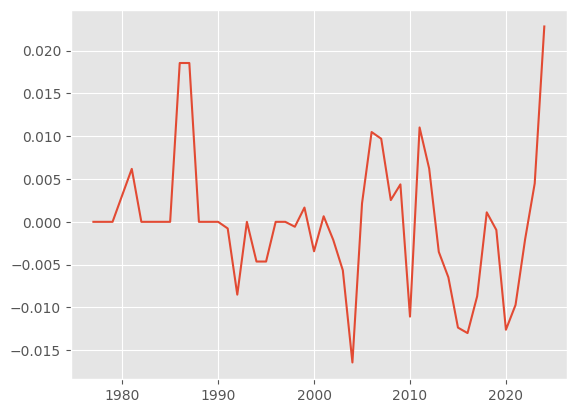

In [36]:
plt.plot(data_diff.index, data_diff.lending)
plt.show()

In [37]:
adf = adfuller(data_diff['lending'])
print(f'p-value is {np.round(adf[1],2)}')

p-value is 0.01


Trying a second order difference for exploration

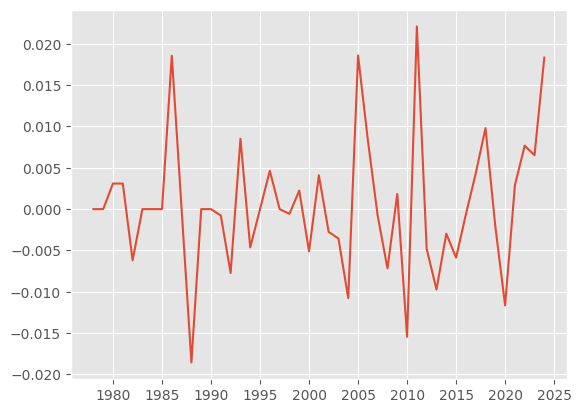

In [38]:
data_diff_2 = data.diff().diff().dropna()
plt.plot(data_diff_2.index, data_diff_2.lending)
plt.show()

From here on, the analysis will be carried out for the data with difference order.

In [46]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [54]:
data_diff = data_diff.drop('rate', axis=1)

In [56]:
train_size = int(len(data_diff) * 0.8)

train = data_diff.iloc[:train_size]
test = data_diff.iloc[train_size:]

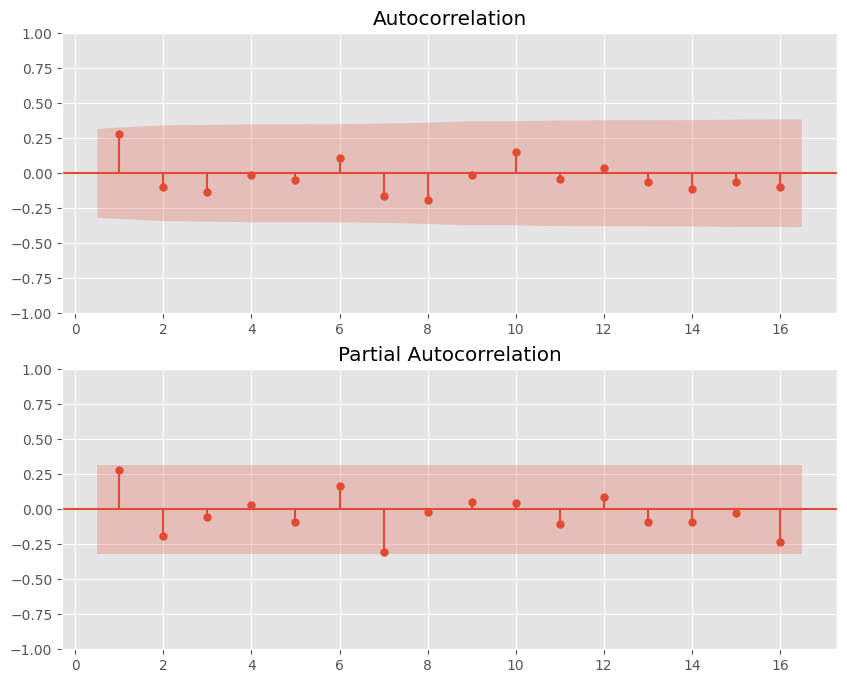

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (10, 8))
plot_acf(train, zero=False, ax=ax1)
plot_pacf(train, zero=False, ax=ax2)
plt.show()

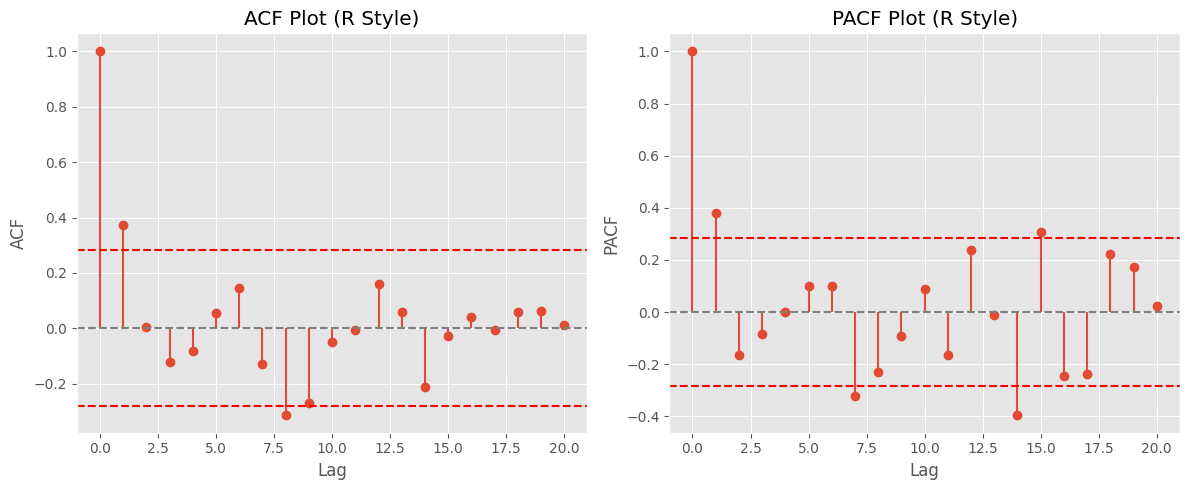

In [74]:
from statsmodels.graphics.tsaplots import acf, pacf
# Compute ACF and PACF values
acf_values = acf(data_diff['lending'], nlags=20)
pacf_values = pacf(data_diff['lending'], nlags=20)

# Generate lags for x-axis
lags = np.arange(len(acf_values))

# Plot ACF with lines
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.stem(lags, acf_values, basefmt=" ")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(data_diff['lending'])), linestyle='--', color='red')
plt.axhline(y=-1.96 / np.sqrt(len(data_diff['lending'])), linestyle='--', color='red')
plt.title('ACF Plot (R Style)')
plt.xlabel('Lag')
plt.ylabel('ACF')

# Plot PACF with lines
plt.subplot(122)
plt.stem(lags, pacf_values, basefmt=" ")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(data_diff['lending'])), linestyle='--', color='red')
plt.axhline(y=-1.96 / np.sqrt(len(data_diff['lending'])), linestyle='--', color='red')
plt.title('PACF Plot (R Style)')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()


In [68]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(data_diff['lending'], lags=[10], return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
10  21.034627   0.020853


In [75]:
train_size = int(len(data) * 0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

## Forecasting

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 


Out-of-sample RMSE: 0.0394
In-sample RMSE: 0.0088


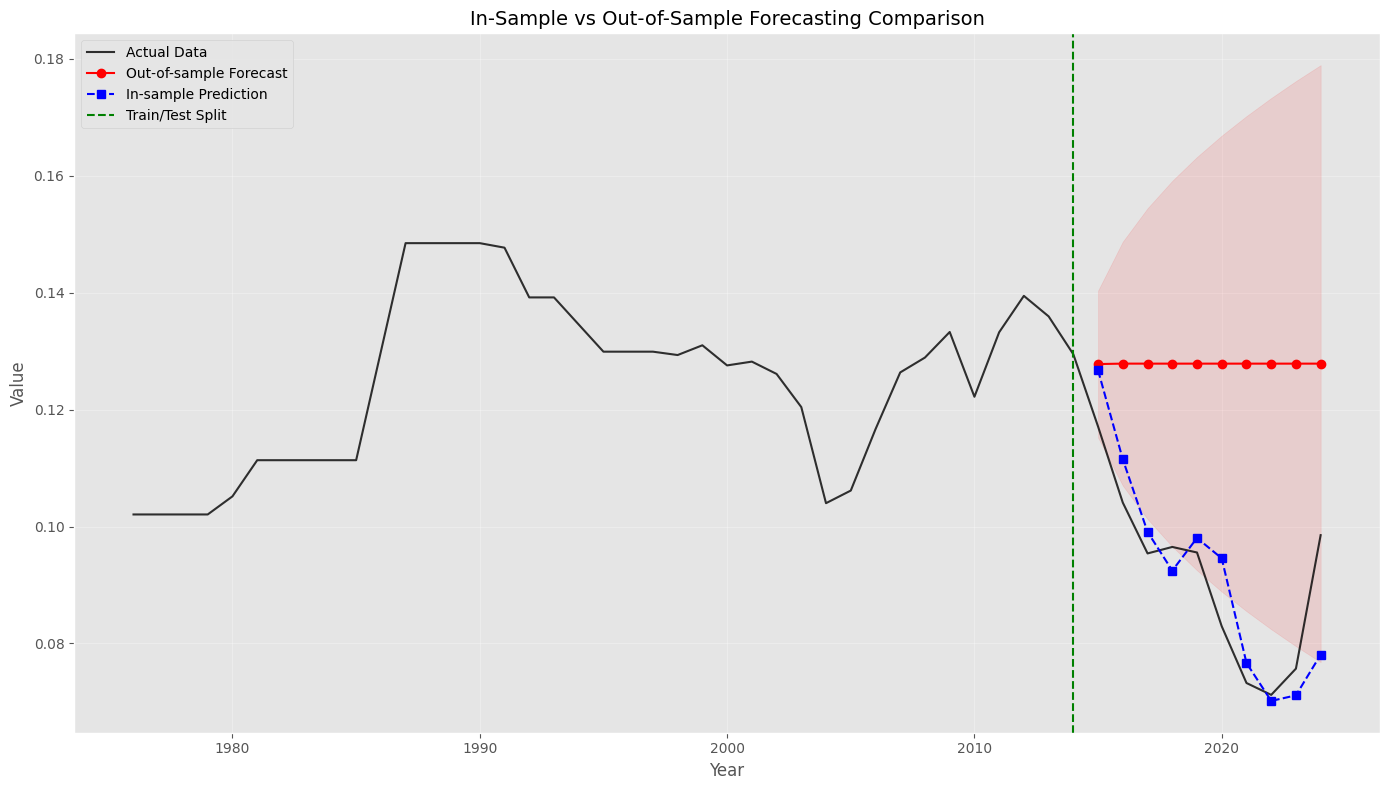

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [91]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


## 2. Out-of-Sample Forecasting
# Fit model on training data only
model_oos = ARIMA(train.lending, order=(1,1,1))  # Adjust order as needed
model_oos_fit = model_oos.fit()

# Forecast the test period (9 steps ahead)
forecast_oos = model_oos_fit.get_forecast(steps=len(test))
forecast_oos_mean = forecast_oos.predicted_mean
forecast_oos_ci = forecast_oos.conf_int()

## 3. In-Sample Fitting
# Fit model on complete dataset (train + test)
model_ins = ARIMA(data.lending, order=(1,1,1))  # Same order as out-of-sample
model_ins_fit = model_ins.fit()

# Get in-sample predictions for entire series
predictions_ins = model_ins_fit.get_prediction()
predictions_ins_mean = predictions_ins.predicted_mean
predictions_ins_ci = predictions_ins.conf_int()

## 4. Calculate RMSE
# Out-of-sample RMSE (test period only)
rmse_oos = np.sqrt(mean_squared_error(test.lending, forecast_oos_mean))

# In-sample RMSE (test period only)
ins_test_pred = predictions_ins_mean[test.index]
rmse_ins = np.sqrt(mean_squared_error(test.lending, ins_test_pred))

print(f"\nOut-of-sample RMSE: {rmse_oos:.4f}")
print(f"In-sample RMSE: {rmse_ins:.4f}")

## 5. Plotting Results
plt.figure(figsize=(14, 8))

# Plot complete series
plt.plot(data.lending, label='Actual Data', color='black', alpha=0.8)

# Plot out-of-sample forecast
plt.plot(forecast_oos_mean.index, forecast_oos_mean, 
         'ro-', label='Out-of-sample Forecast')
plt.fill_between(forecast_oos_mean.index,
                forecast_oos_ci.iloc[:,0],
                forecast_oos_ci.iloc[:,1],
                color='red', alpha=0.1)

# Plot in-sample predictions (test period only)
plt.plot(ins_test_pred.index, ins_test_pred,
         'bs--', label='In-sample Prediction')
# plt.fill_between(ins_test_pred.index,
#                 predictions_ins_ci.loc[test.index, 'lower y'],
#                 predictions_ins_ci.loc[test.index, 'upper y'],
#                 color='blue', alpha=0.1)

# Add vertical line for train/test split
plt.axvline(x=train.index[-1], color='green', linestyle='--', 
           label='Train/Test Split')

# Formatting
plt.title('In-Sample vs Out-of-Sample Forecasting Comparison', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Additional Comparison Plot (Test Period Only)
plt.figure(figsize=(14, 6))

# Plot test data
# plt.plot(test, 'ko-', label='Actual Test Data')

# Plot out-of-sample forecast
# plt.plot(forecast_oos_mean, 'ro-', label='Out-of-sample Forecast')
# plt.fill_between(forecast_oos_mean.index,
#                 forecast_oos_ci.iloc[:,0],
#                 forecast_oos_ci.iloc[:,1],
#                 color='red', alpha=0.1)

# # Plot in-sample predictions
# plt.plot(ins_test_pred, 'bs--', label='In-sample Prediction')
# plt.fill_between(ins_test_pred.index,
#                 predictions_ins_ci.loc[test.index, 'lower y'],
#                 predictions_ins_ci.loc[test.index, 'upper y'],
#                 color='blue', alpha=0.1)

# plt.title('Test Period Comparison', fontsize=14)
# plt.xlabel('Year')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()